In [1]:
import numpy as np
import sympy as sp
import time as ti
from skimage.metrics import structural_similarity
from PIL import Image
from scipy import interpolate
import matplotlib.pyplot as plt

# Tarea 3:Interpolación Bicúbica

## Instrucciones

* La tarea es individual.
* Las consultas sobre las tareas se deben realizar por medio de la plataforma Aula.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`).
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, entre otras, así como la correcta implementación de algoritmos de forma vectorizada.
*  **El archivo de entrega debe denominarse ROL-tarea-numero.ipynb**. _De no respetarse este formato existirá un descuento de **50 puntos**_
* La fecha de entrega es el viernes 24 de Julio a las **18:00 hrs**.  Se aceptarán entregas hasta las 19:00 hrs sin descuento en caso de existir algun problema, posteriormente existirá un descuento lineal hasta las 20:00 hrs del mismo día.
* Las tareas que sean entregadas antes del jueves a mediodía recibirán una bonificación de 10 puntos
* Debe citar cualquier código ajeno utilizado (incluso si proviene de los Jupyter Notebooks del curso).


## Introducción

En la siguiente tarea estudiaremos un método de interpolación denominado **Interpolación Bicúbica**, utilizada frecuentemente sobre imágenes. Aplicaremos el método para aumentar la resolución de una imagen intentando preservar las propiedades de la versión original.

## Contexto

Supongamos que usted conoce $f$ y las derivadas $f_x$, $f_y$ y $f_{xy}$ dentro de las coordenadas $(0,0),(0,1),(1,0)$ y $(1,1)$ de un cuadrado unitario. La superficie que interpola estos 4 puntos es:

$$
p(x,y) = \sum\limits_{i=0}^3 \sum_{j=0}^3 a_{ij} x^i y^j.
$$

Como se puede observar el problema de interpolación se resume en determinar los 16 coeficientes $a_{ij}$ y para esto se genera un total de $16$ ecuaciones utilizando los valores conocidos de $f$,$f_x$,$f_y$ y $f_{xy}$. Por ejemplo, las primeras $4$ ecuaciones son:

$$
\begin{aligned}
f(0,0)&=p(0,0)=a_{00},\\
f(1,0)&=p(1,0)=a_{00}+a_{10}+a_{20}+a_{30},\\
f(0,1)&=p(0,1)=a_{00}+a_{01}+a_{02}+a_{03},\\
f(1,1)&=p(1,1)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=0}^{3}a_{ij}.
\end{aligned}
$$

Para las $12$ ecuaciones restantes se debe utilizar:

$$
\begin{aligned}
f_{x}(x,y)&=p_{x}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=0}^{3}a_{ij}ix^{i-1}y^{j},\\
f_{y}(x,y)&=p_{y}(x,y)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=1}^{3}a_{ij}x^{i}jy^{j-1},\\
f_{xy}(x,y)&=p_{xy}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=1}^{3}a_{ij}ix^{i-1}jy^{j-1}.
\end{aligned}
$$


Una vez planteadas las ecuaciones, los coeficientes se pueden obtener al resolver el problema $A\alpha=x$, donde $\alpha=\left[\begin{smallmatrix}a_{00}&a_{10}&a_{20}&a_{30}&a_{01}&a_{11}&a_{21}&a_{31}&a_{02}&a_{12}&a_{22}&a_{32}&a_{03}&a_{13}&a_{23}&a_{33}\end{smallmatrix}\right]^T$ y ${\displaystyle x=\left[{\begin{smallmatrix}f(0,0)&f(1,0)&f(0,1)&f(1,1)&f_{x}(0,0)&f_{x}(1,0)&f_{x}(0,1)&f_{x}(1,1)&f_{y}(0,0)&f_{y}(1,0)&f_{y}(0,1)&f_{y}(1,1)&f_{xy}(0,0)&f_{xy}(1,0)&f_{xy}(0,1)&f_{xy}(1,1)\end{smallmatrix}}\right]^{T}}$.


En un contexto más aplicado, podemos hacer uso de la interpolación bicúbica para aumentar la resolución de una imagen. Supongamos que tenemos la siguiente imagen de tamaño $5 \times 5$:

<img src="img1.png" width="20%"/>

Podemos ir tomando segmentos de la imagen de tamaño $2 \times 2$ de la siguiente forma:

<img src="img2.png" width="50%"/>

Por cada segmento podemos generar una superficie interpoladora mediante el algoritmo de interpolación cubica. Para el ejemplo anterior estariamos generando $16$ superficies interpoladoras distintas. La idea es hacer uso de estas superficies para estimar los valores de los pixeles correspondienets a una imagen más grande. Por ejemplo, la imagen $5 \times 5$ la podemos convertir a una imagen de $9 \times 9$ agregando un pixel entre cada par de pixeles originales además de uno en el centro para que no quede un hueco.

<img src="img3.png" width="50%"/>

Aca los pixeles verdes son los mismos que la imagen original y los azules son obtenidos de evaluar cada superficie interpoladora. Notar que existen pixeles azules que se pueden obtener a partir de dos superficies interpoladoras distintas, en esos casos se puede promediar el valor de los pixeles o simplemente dejar uno de los dos. 

Para trabajar con la interpolación bicubica necesitamos conocer los valores de $f_x$, $f_y$ y $f_{xy}$. En el caso de las imagenes solo tenemos acceso al valor de cada pixel por lo que deberemos estimar cual es el valor de estos. Para estimar $f_x$ haremos lo siguiente:

Para estimar el valor de $f_x$ en cada pixel haremos una interpolación con los algoritmos conocidos, usando tres pixels en dirección de las filas, luego derivaremos el polinomio obtenido y finalmente evaluaremos en la posición de interes. La misma idea aplica para $f_y$ solo que ahora interpolaremos en dirección de las columnas.

<img src="img5.png" width="60%"/>

Por ejemplo si queremos obtener el valor de $f_x$ en la posición $(0,0)$ (imagen de la izquierda) entonces haremos una interpolación de Lagrange utilizando los pixeles $(0,0),(0,1)$ y $(0,2)$. Derivaremos el polinomio interpolador y evaluaremos en $(0,0)$. Por otro lado si queremos obtener el valor de $f_y$ en la posición $(0,0)$ (imagen de la derecha) entonces interpolaremos los pixeles $(0,0),(1,0)$ y $(2,0)$. Luego derivaremos el polinomio interpolador y evaluaremos en $(0,0)$.

Para obtener $f_{xy}$ seguiremos la idea anterior. Solo que esta vez se utilizaran los valores de $f_y$ y se interpolaran estos en dirección de las filas.

# Preguntas

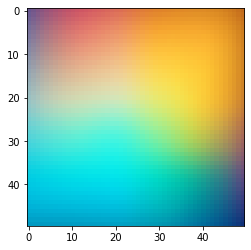

In [30]:
#Codigo para abrir y visualizar imágenes
img = Image.open('imagenes_prueba/gradient.png')
img = img.convert('RGB')
array=np.array(img)
imgplot = plt.imshow(array)
plt.show()

## 1. Interpolación bicubica

### 1.1  Obtener derivadas (30 puntos)

Implemente la función `derivativeValues` que reciba como input un arreglo con valores, el método de interpolación y si es que se considera el uso de  los puntos de chebyshev . La función debe retornar un arreglo de igual dimensión con los valores de las derivadas de los puntos obtenidas

Los métodos de interpolación serán representados por los siguientes valores

* Interpolación de lagrange: `'lagrange'`
* Diferencias divididas de Newton: `'newton'`
* Spline cubica: `'spline3'`


In [3]:
#Codigo para diferencias divididas obtenidas del github del curso
def Divided_Differences(x, y):
    dd = np.array([y])
    for i in range(len(x)-1):
        ddi = []
        for a in range(len(x)-i-1):
            ddi.append((dd[i][a+1]-dd[i][a])/(x[a+i+1]-x[a]))
        ddi = np.append(ddi,np.full((len(x)-len(ddi),),0.0))
        dd = np.append(dd,[ddi],axis=0)
    return np.array(dd)
def Newton(x, y, show=False):
    # We calculate the divided differences and store them in a data structure
    dd = Divided_Differences(x,y)
    
    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); print([(x[i],y[i]) for i in range(len(x))])
        xS = sp.Symbol('x')
        N = np.dot(dd[:,0],np.append([1],[np.prod(xS-x[:i]) for i in range(1,len(dd))]))
        print('Interpolation Function: ');
        print(N)
        
    # Finally, we return a data structure with our interpolating polynomial
    D = {'M':'Newton',
         'P':dd[:,0],
         'x':x,
         'y':y}
    return D

In [4]:
def derivativeValues(values, method, cheb):
    """
    Parameters
    ----------
    values:	(int array) points values
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used

    Returns
    -------
    d:	(float array) derivative value of interpolated points

    """
    d = []
    a = 0
    b = values.size-1
    n = b + 1
    if cheb:
        points = []
        for i in range(1,n+1):
            points.append((b+a)/2 + (b-a)*np.cos(((2*i-1)*np.pi)/(2*(n)))/2)
    else:
        points = list(range(b+1))   
    
    points.sort()
    points = np.array(points)
    if method == "lagrange":
        inter = interpolate.lagrange(points, values)
        der = inter.deriv()
        for i in points:
             d.append(der(i))
        
    elif method == "newton":
        inter = Newton(points, values)["P"]
        for i in points:
            suma = inter[1]
            suma += inter[2]*((i - points[0]) + (i - points[1]))
            r = (i - points[0])*(i - points[1])
            rder = (i - points[0]) + (i - points[1])
            
            for z in range(3,len(points)):
                rder = (r+rder*(i-points[z-1]))
                r = r*(i - points[z-1])
                suma += inter[z]*rder
    
            d.append(suma)
                 
        
        
    elif method == "spline3":
        inter = interpolate.CubicSpline(points, values)
        der = inter.derivative()
        for i in points:
            d.append(der(i))
        
    d = np.array(d)
    return d


### 1.2 Interpolación de imagen (50 puntos)
Implemente la función `bicubicInterpolation` que reciba como input la matriz de la imagen y cuantos píxeles extra se quiere agregar entre los píxeles originales y el algoritmo de interpolación a utilizar. La función debe retornar la matriz con la imagen de dimensión nueva. Considere que se debe aplicar el método de interpolación en cada canal RGB por separado.

In [5]:
def powaDeriv(image, method, cheb):
    """
    Parameters
    ----------
    image:	(nxn array)	 values of one color of the image
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used

    Returns
    -------
    l:	(3x(n-1)x(n-1) array) values of the three derivatives
    """
    
    n = image.shape[0]
    fx = np.zeros((n,n))
    fy = np.zeros((n,n))
    fxy = np.zeros((n,n))
    #x e y
    for i in range(n):
        for j in range(n):
            if j +1 < n and j > 0:
                arr = np.array([image[i,j-1],image[i,j],image[i,j+1]])
                der = derivativeValues(arr, method,cheb)
                if j == 1:
                    fx[i,j-1] = der[0] 
                elif j == n-2:
                    fx[i,j+1] = der[2]
                fx[i,j] = der[1]
            if i + 1 < n and i > 0:
                arr = np.array([image[i-1,j],image[i,j],image[i+1,j]])
                der = derivativeValues(arr, method,cheb)
                if i == 1:
                    fy[i-1,j] = der[0] 
                elif i == n-2:
                    fy[i+1,j] = der[2]
                fy[i,j] = der[1]
                
            
    #xy
    for i in range(n):
        for j in range(1,n-1):
            arr = np.array([fy[i,j-1],fy[i,j],fy[i,j+1]])
            der = derivativeValues(arr, method, cheb)
            
            if j == 1:
                fxy[i,j-1] = der[0] 
            elif j == n-2:
                fxy[i,j+1] = der[2]
            fxy[i,j] = der[1]
    l = np.array([fx,fy,fxy])
    return l




def coefi(color, der, n):
    """
    Parameters
    ----------
    color:	(nxn array) one colorimage array 
    der:	(n-1xn-1 array)	derivative values
    n:	(int)	 shape of the matrix


    Returns
    -------
    cuadrado:	((n-1)x(n-1)x4x4 array) matrix with all the coefficients of a color

    """
    
    A = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
         [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0],
         [0, 0, 0, 0, 0, 1, 2, 3, 0, 2, 4, 6, 0, 3, 6, 9]]
    
    
    cuadrados = []
    for i in range(n-1):
        mini = []
        for j in range(n-1):
            ekis = []
            ekis.append(color[i,j])
            ekis.append(color[i+1,j])
            ekis.append(color[i,j+1])
            ekis.append(color[i+1,j+1])

            ekis.append(der[0][i,j])
            ekis.append(der[0][i+1,j])
            ekis.append(der[0][i,j+1])
            ekis.append(der[0][i+1,j+1])

            ekis.append(der[1][i,j])
            ekis.append(der[1][i+1,j])
            ekis.append(der[1][i,j+1])
            ekis.append(der[1][i+1,j+1])

            ekis.append(der[2][i,j])
            ekis.append(der[2][i+1,j])
            ekis.append(der[2][i,j+1])
            ekis.append(der[2][i+1,j+1])
            
            ekis = np.array(ekis)      
            
            sol = np.linalg.solve(A, ekis)
            sol = sol.reshape((4,4))
            solt = sol.T
            mini.append(solt)
        cuadrados.append(mini)
    return cuadrados






def eva01(x,y,coef):
    """
    Parameters
    ----------
    x:	(float)	x value to be evaluated 
    y:	(float)	y value to be evaluated
    coef:	(4x4 array)	 matrix of the coefficients


    Returns
    -------
    suma:	(int) value of the polynom evaluated

    """
    
    suma = 0
    for i in range(4):
        for j in range(4):
            suma+= coef[i][j]*(x**i)*(y**j)
    
    suma = np.round(suma)
    if suma > 255:
        suma = 255
    elif suma < 0:
        suma = 0
    return int(suma)
    

In [6]:
def bicubicInterpolation(image, interiorPixels, method,cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	interpolation method
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used


    Returns
    -------
    newImage:	(nxnx3 array) image array in RGB format

    """
    
    n = image.shape[0]
    r = np.zeros((n,n))
    b = np.zeros((n,n))
    g = np.zeros((n,n))

    for i in range(0,n):
        for j in range(0,n):
            r[i,j] = image[i,j][0]
            b[i,j] = image[i,j][1]
            g[i,j] = image[i,j][2]
            
    red = powaDeriv(r, method, cheb)
    blue = powaDeriv(b, method, cheb)
    green = powaDeriv(g, method, cheb)

    rco = coefi(r, red, n)
    bco = coefi(b, blue, n)
    gco = coefi(g, green, n)
    newImage = np.zeros((n+(n-1)*interiorPixels, n+(n-1)*interiorPixels, 3)).astype(int)
    val = np.linspace(0,1,interiorPixels+2)
    for i in range(n-1):  
        for j in range(n-1):
            for z in range(val.size):
                for v in range(val.size):
                    newImage[i*(interiorPixels+1)+z,j*(interiorPixels+1)+v,0] = eva01(val[z],val[v],rco[i][j])
                    newImage[i*(interiorPixels+1)+z,j*(interiorPixels+1)+v,1] = eva01(val[z],val[v],bco[i][j])
                    newImage[i*(interiorPixels+1)+z,j*(interiorPixels+1)+v,2] = eva01(val[z],val[v],gco[i][j])
         
    
    return newImage

In [31]:
a = bicubicInterpolation(array, 2, "lagrange",False)

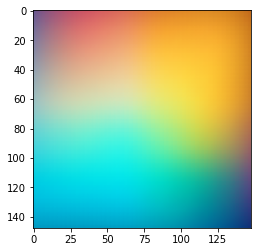

In [32]:

arra=np.array(a)
imgplot = plt.imshow(arra)
plt.show()

## 2. Evaluacion de algoritmos



### 2.1 Tiempo de ejecucion 
Implemente la funcion `timeInterpolation` que mida el tiempo de interpolacion de una imagen dado el algoritmo de interpolacion , en segundos.(5 puntos)

In [8]:
def timeInterpolation(image, interiorPixels, method,cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	interpolation method
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used


    Returns
    -------
    time:	(float) time in seconds

    """
    start = ti.time()
    a = bicubicInterpolation(array, interiorPixels, method, cheb)
    end = ti.time()
    time = end-start
    return time

***Pregunta: ¿Cual es el metodo que presenta mayor velocidad en general? (5 puntos)***

Utilizando los ejemplos que se muestran abajo, se puede observar que utilizando Diferencias divididas de Newton, los puntos de cheb al parecen lo afectan, ya que hay veces que es mas rapido y a veces mas lento

# Pruebas para la respuesta sobre el tiempo de ejecucion 

Esta comentado para evitar que se corra esta parte si no se quiere

In [9]:
#timeInterpolation(array, 1, "lagrange",True)

In [10]:
#timeInterpolation(array, 1, "lagrange",False)

In [11]:
#timeInterpolation(array, 1, "spline3",True)

In [12]:
#timeInterpolation(array, 1, "spline3",False)

In [13]:
#timeInterpolation(array, 1, "newton",True)

In [14]:
#timeInterpolation(array, 1, "newton",False)

### 2.2 Calculo de error
Implemente la funcion `errorInterpolation` la cual debe obtener el error de la imagen obtenida comparandola con una de referencia. El error debe ser calculado utilizando el indice SSIM (Structural similarity) (5 puntos)

In [15]:
def errorInterpolation(original,new):
    """
    Parameters
    ----------
    image:	(nxn array) original image array in RGB format
    new:	(nxn array) new image array in RGB format obtained from interpolation


    Returns
    -------
    error:	(float) difference between images 

    """
    n = original.shape[0]
    error = 1-structural_similarity(original, new, multichannel=True, data_range=n)
    return error

***Pregunta: ¿Cual metodo presenta menor error? (5 puntos)***

En base a las pruebas hechas, se puede observar que los 3 metodos poseen el mismpo error si son utilizados sin puntos de chebyshev. Esto puede que dependa de los casos de prueba que se utilicen.

# Pruebas para la respuesta sobre el error en la interpolacion

In [16]:
img = Image.open('imagenes_prueba/sunset.png')
img = img.convert('RGB')
array = np.array(img)

ori = Image.open('imagenes_prueba/sunset_1pixel.png')
ori = ori.convert('RGB')
original = np.array(ori)

In [17]:
#new = bicubicInterpolation(array, 1, "lagrange", True)
#a = errorInterpolation(original,new)
#a

In [18]:
#new = bicubicInterpolation(array, 1, "lagrange", False)
#a = errorInterpolation(original,new)
#a

In [19]:
#new = bicubicInterpolation(array, 1, "newton", True)
#a = errorInterpolation(original,new)
#a

In [20]:
#new = bicubicInterpolation(array, 1, "newton", False)
#a = errorInterpolation(original,new)
#a

In [21]:
#new = bicubicInterpolation(array, 1, "spline3", True)
#a = errorInterpolation(original,new)
#a

In [22]:
#new = bicubicInterpolation(array, 1, "spline3", False)
#a = errorInterpolation(original,new)
#a

* Solo trabajaremos con imagenes cuadradas
* En el caso que el valor interpolado de un punto sea mayor a 255 o menor a 0, este se trunca a 255 o 0 respectivamente
* Esta permitido el uso de sympy para calcular derivadas y para construir el polinomio interpolador 
* El calculo de error puede ser calculado utilizando la imagen en escala de grises [(ejemplo)](https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html)